# Corridor Metrics Workflow

This notebook demonstrates how to compute cue hit rates and lick densities as a function of corridor position using the reusable helpers in `behavioral_analysis.analysis.corridor_metrics`.

## Setup
The workflow below assumes you have Unity log exports (JSON files) in the root of the repository. Update `LOG_PATH` in the next cell to point to the log you want to analyse. If the path does not exist, a small synthetic dataset is generated so you can still run through the example.

In [1]:
from pathlib import Path
import sys

REPO_ROOT = Path.cwd()
SRC_CANDIDATES = [
    REPO_ROOT / 'src',
    REPO_ROOT.parent / 'src',
    (REPO_ROOT / '..' / 'src').resolve(),
]

for candidate in SRC_CANDIDATES:
    if candidate.exists():
        src_path = candidate.resolve()
        break
else:
    raise RuntimeError('Could not locate the package src directory. Update the path setup cell.')

if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

print(f'Added {src_path} to sys.path')

Added /groups/spruston/home/moharb/DELTA_Behavior/src to sys.path


In [2]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

from behavioral_analysis.analysis import (
    compute_hit_rates_by_position,
    compute_lick_rates_by_position,
    load_log_entries,
)


### Load log entries

In [3]:
LOG_PATH = Path("/groups/spruston/home/moharb/DELTA_Behavior/Log BM35 2025-09-22 session 1.json")

if LOG_PATH.exists():
    entries = load_log_entries(LOG_PATH)
    print(f"Loaded {len(entries)} log entries from {LOG_PATH.name}")
else:
    print("LOG_PATH does not exist; using synthetic demo data.")
    entries = [
        {"msg": "Path Position", "data": {"position": 120}},
        {"msg": "Cue Result", "data": {"position": 150, "hasGivenReward": True}},
        {"msg": "Path Position", "data": {"position": 1120}},
        {"msg": "Cue Result", "data": {"position": 1180, "hasGivenReward": False}},
        {"msg": "Cue Result", "data": {"position": 1250, "hasGivenReward": True}},
        {"msg": "Path Position", "data": {"position": 2120}},
        {"msg": "Cue Result", "data": {"position": 2140, "hasGivenReward": True}},
        {"msg": "Cue Result", "data": {"position": 2250, "hasGivenReward": False}},
        {"msg": "Path Position", "data": {"position": 2300}},
        {"msg": "Lick"},
        {"msg": "Path Position", "data": {"position": 2450}},
        {"msg": "Lick"},
        {"msg": "Lick"},
        {"msg": "Path Position", "data": {"position": 3120}},
        {"msg": "Lick"},
    ]


Loaded 241715 log entries from Log BM35 2025-09-22 session 1.json


## Hit rate by corridor position
Choose a bin size that matches the resolution you care about. The default used in the original script was 1000 corridor units.

In [4]:
hit_bin_size = 1000

hit_bins = compute_hit_rates_by_position(entries, bin_size=hit_bin_size)
hit_df = pd.DataFrame([
    {"bin_start": bin_stats.bin_start,
     "hits": bin_stats.hits,
     "total": bin_stats.total,
     "hit_rate": bin_stats.hit_rate}
    for bin_stats in hit_bins
])
hit_df

,bin_start,hits,total,hit_rate
0,5000,6,15,0.400000
1,6000,11,16,0.687500
2,7000,5,12,0.416667
3,8000,6,14,0.428571
4,12000,4,11,0.363636
5,13000,7,19,0.368421
6,14000,4,15,0.266667
7,15000,4,12,0.333333
8,19000,10,18,0.555556
9,20000,7,17,0.411765


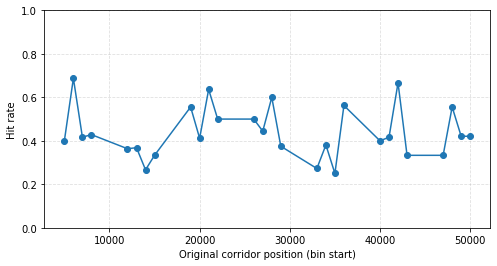

In [5]:
if not hit_df.empty:
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(hit_df['bin_start'], hit_df['hit_rate'], marker='o', linewidth=1.5)
    ax.set_xlabel('Original corridor position (bin start)')
    ax.set_ylabel('Hit rate')
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle='--', alpha=0.4)
    plt.show()
else:
    print('No hit bins available. Check that the log contains cue results.')


## Lick density by corridor position
For lick rate we typically use a finer spatial resolution.

In [6]:
lick_bin_size = 200

lick_bins = compute_lick_rates_by_position(entries, bin_size=lick_bin_size)
lick_df = pd.DataFrame([
    {"bin_start": bin_stats.bin_start,
     "bin_end": bin_stats.bin_end,
     "lick_count": bin_stats.lick_count,
     "lick_rate_per_unit": bin_stats.lick_rate_per_unit}
    for bin_stats in lick_bins
])
lick_df

,bin_start,bin_end,lick_count,lick_rate_per_unit
0,0,200,16,0.080
1,200,400,5,0.025
2,400,600,9,0.045
3,600,800,3,0.015
4,800,1000,3,0.015
...,...,...,...,...
245,49000,49200,30,0.150
246,49200,49400,29,0.145
247,49400,49600,22,0.110
248,49600,49800,22,0.110


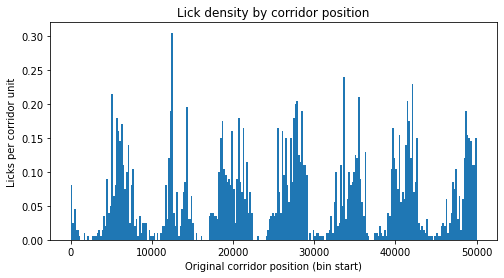

In [7]:
if not lick_df.empty:
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(lick_df['bin_start'], lick_df['lick_rate_per_unit'], width=lick_bin_size, align='edge')
    ax.set_xlabel('Original corridor position (bin start)')
    ax.set_ylabel('Licks per corridor unit')
    ax.set_title('Lick density by corridor position')
    plt.show()
else:
    print('No lick bins available. Ensure the log includes path and lick events.')


## Export results (optional)
You can replicate the behaviour of the original scripts by writing the results to TSV files.


In [ ]:
output_prefix = LOG_PATH.with_suffix('') if LOG_PATH.exists() else Path('demo_output')

hit_output = output_prefix.with_name(f'{output_prefix.stem}_hit_rate_by_position.tsv')
lick_output = output_prefix.with_name(f'{output_prefix.stem}_lick_rate_by_position.tsv')

if not hit_df.empty:
    hit_df.to_csv(hit_output, sep='	', index=False)
    print(f'Hit-rate table saved to {hit_output}')
if not lick_df.empty:
    lick_df.to_csv(lick_output, sep='	', index=False)
    print(f'Lick-rate table saved to {lick_output}')
